Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### We will import the data from google drive and unzip files to test and train folders to read the data

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [3]:
#umcomment this code if running on google colab and reading data from google drive

#from google.colab import drive
#drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
#google drive is mounted and the zip file is prsent at the root level. 
#we need to unzip the file provided by upgrad into seperate test and train folders
#Since the data provided is already seperated in train and test we can just unzip the file to root

#umcomment this code if running on google colab and reading data from google drive

#import os
#os.chdir('gdrive/My Drive')  #change dir

#!unzip -q CNN_assignment -d /




In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:/Users/Vineet/Downloads/SkinCancerISIC/Train")
data_dir_test = pathlib.Path('C:/Users/Vineet/Downloads/SkinCancerISIC/Test')

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size= (img_height , img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size= (img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Let's visualize one instance of all the nine classes present in the dataset

In [14]:
import matplotlib.pyplot as plt

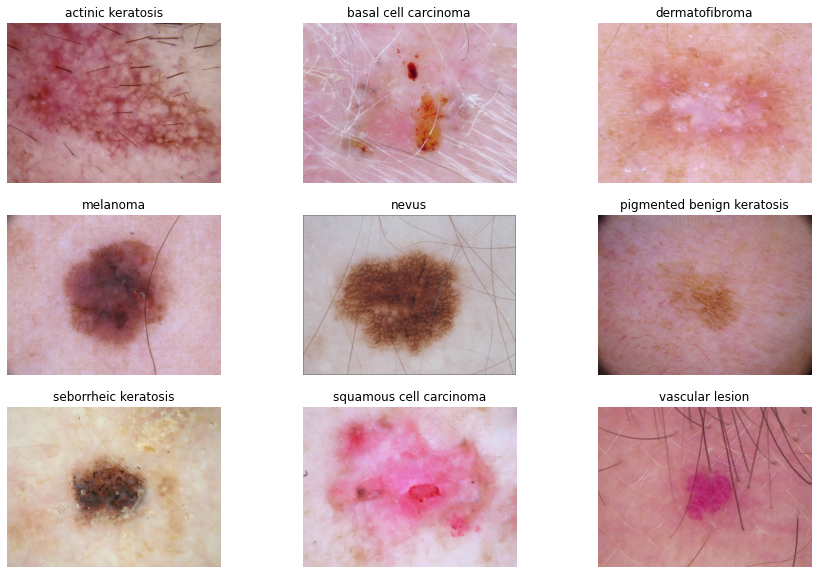

In [15]:
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [16]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32, 9)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(ex)

[]


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [38]:

num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model =  tf.keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choosing an appropirate optimiser and loss function for model training 

In [29]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_8 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_9 (Activation)   (None, 90, 90, 32)        0         
                                                      

### Train the model

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 207ms/step - loss: 2.0489 - accuracy: 0.1970 - val_loss: 2.0273 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 11s 204ms/step - loss: 2.0081 - accuracy: 0.2394 - val_loss: 1.9710 - val_accuracy: 0.3512
Epoch 3/20
56/56 [==============================] - 11s 200ms/step - loss: 1.9809 - accuracy: 0.2740 - val_loss: 1.9268 - val_accuracy: 0.3624
Epoch 4/20
56/56 [==============================] - 12s 211ms/step - loss: 1.9656 - accuracy: 0.2533 - val_loss: 1.8999 - val_accuracy: 0.3400
Epoch 5/20
56/56 [==============================] - 13s 237ms/step - loss: 1.9243 - accuracy: 0.2896 - val_loss: 1.9102 - val_accuracy: 0.2170
Epoch 6/20
56/56 [==============================] - 13s 237ms/step - loss: 1.9095 - accuracy: 0.2796 - val_loss: 2.0170 - val_accuracy: 0.2774
Epoch 7/20
56/56 [==============================] - 13s 240ms/step - loss: 1.8644 - accuracy: 0.3248 - val_loss: 1.7496 - val_accuracy: 0.3311

### It is evident that our model is not working as expected. This is a case of underfitting
The validation loss is not decreasing much and accuracy on traing and validation set is 46% and 49% respectively after 20 epochs. 
We need to revisit the loss function, optimizer, data pre processing (augmentation) etc.

## Create the model again

In [39]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training the model again (using different optimizer)

In [40]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 187ms/step - loss: 1.9916 - accuracy: 0.2840 - val_loss: 1.9794 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 10s 187ms/step - loss: 1.6715 - accuracy: 0.4068 - val_loss: 1.5544 - val_accuracy: 0.4765
Epoch 3/20
56/56 [==============================] - 11s 189ms/step - loss: 1.4715 - accuracy: 0.4754 - val_loss: 1.4234 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 11s 193ms/step - loss: 1.3506 - accuracy: 0.5251 - val_loss: 1.4502 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 12s 221ms/step - loss: 1.2911 - accuracy: 0.5530 - val_loss: 1.4727 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 12s 222ms/step - loss: 1.2027 - accuracy: 0.5737 - val_loss: 1.4024 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 12s 220ms/step - loss: 1.1572 - accuracy: 0.5843 - val_loss: 1.4489 - val_accuracy: 0.5101

### Visualizing the results

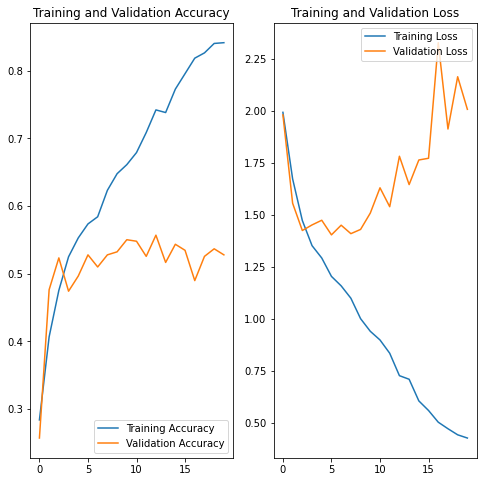

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Now we have encountered overfitting as training accuracy is as high as 84% but validation accuracy drops to 53%
###### Also we can see that after about 5 epochs the training accuracy keeps on increasing but validation accuracy stagnates

# We must solve the problem of overfitting

### Distribution of classes in the training dataset.
 Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [42]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

####  `seborrheic keratosis` class has the least number of samples
####  `melanoma`, `pigmented benign keratosis` and `basal cell carcinoma` classes dominate the data in terms proportionate number of samples

##  Rectify the class imbalance
Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
!pip install Augmentor

In [68]:
path_to_training_dataset=r"C:\Users\Vineet\Downloads\SkinCancerISIC\Train"
for i in class_names:
    print(path_to_training_dataset +'\\'+ i)

C:\Users\Vineet\Downloads\SkinCancerISIC\Train\actinic keratosis
C:\Users\Vineet\Downloads\SkinCancerISIC\Train\basal cell carcinoma
C:\Users\Vineet\Downloads\SkinCancerISIC\Train\dermatofibroma
C:\Users\Vineet\Downloads\SkinCancerISIC\Train\melanoma
C:\Users\Vineet\Downloads\SkinCancerISIC\Train\nevus
C:\Users\Vineet\Downloads\SkinCancerISIC\Train\pigmented benign keratosis
C:\Users\Vineet\Downloads\SkinCancerISIC\Train\seborrheic keratosis
C:\Users\Vineet\Downloads\SkinCancerISIC\Train\squamous cell carcinoma
C:\Users\Vineet\Downloads\SkinCancerISIC\Train\vascular lesion


In [69]:
path_to_training_dataset=r"C:\Users\Vineet\Downloads\SkinCancerISIC\Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'\\'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24501AF19A0>: 100%|██████████| 500/500 [00:01<00:00, 325.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24501DB3760>: 100%|██████████| 500/500 [00:01<00:00, 315.90 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24501AE7F40>: 100%|██████████| 500/500 [00:01<00:00, 305.96 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x24501AE1FA0>: 100%|██████████| 500/500 [00:08<00:00, 58.12 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x2452DBFB580>: 100%|██████████| 500/500 [00:08<00:00, 60.73 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24501920940>: 100%|██████████| 500/500 [00:01<00:00, 306.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x24501884370>: 100%|██████████| 500/500 [00:03<00:00, 127.03 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2452DC0B970>: 100%|██████████| 500/500 [00:01<00:00, 292.78 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\Vineet\Downloads\SkinCancerISIC\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2450169D820>: 100%|██████████| 500/500 [00:01<00:00, 297.04 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [70]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Train the model on the data created using Augmentor

In [75]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [76]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [77]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create your model (make sure to include normalization)

In [85]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model =  tf.keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

In [88]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [83]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [84]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [89]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 39s 195ms/step - loss: 2.0847 - accuracy: 0.2161 - val_loss: 1.7137 - val_accuracy: 0.3430
Epoch 2/50
169/169 [==============================] - 40s 237ms/step - loss: 1.6214 - accuracy: 0.3904 - val_loss: 1.3943 - val_accuracy: 0.4469
Epoch 3/50
169/169 [==============================] - 42s 250ms/step - loss: 1.3353 - accuracy: 0.4974 - val_loss: 1.2766 - val_accuracy: 0.5219
Epoch 4/50
169/169 [==============================] - 42s 250ms/step - loss: 1.1827 - accuracy: 0.5619 - val_loss: 1.1938 - val_accuracy: 0.5486
Epoch 5/50
169/169 [==============================] - 42s 251ms/step - loss: 1.0555 - accuracy: 0.6142 - val_loss: 1.0678 - val_accuracy: 0.6021
Epoch 6/50
169/169 [==============================] - 42s 251ms/step - loss: 0.9159 - accuracy: 0.6749 - val_loss: 0.9569 - val_accuracy: 0.6637
Epoch 7/50
169/169 [==============================] - 43s 253ms/step - loss: 0.7937 - accuracy: 0.7188 - val_loss: 1.0259 - val_ac

## Visualize the model results

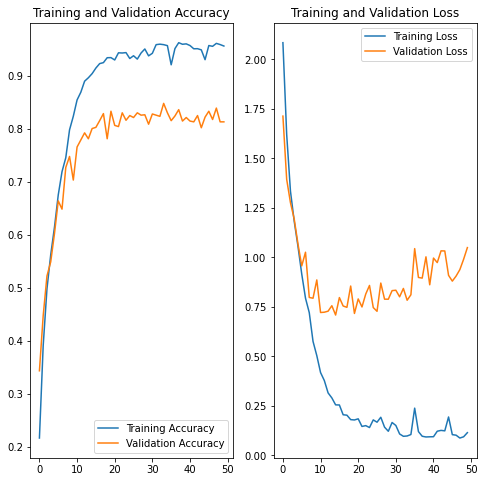

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference
We have solved the problem of overfitting and model is working good for validation set also.
We see oppurtunity to `early stop` during the training phase. However this model is good enough. We will run the model on test set in the end to see how it works

In [91]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [5 4 7 2 5 0 4 1 2 7 1 3 7 7 3 2 7 2 7 0 4 5 3 0 1 4 1 3 6 3 5 3]


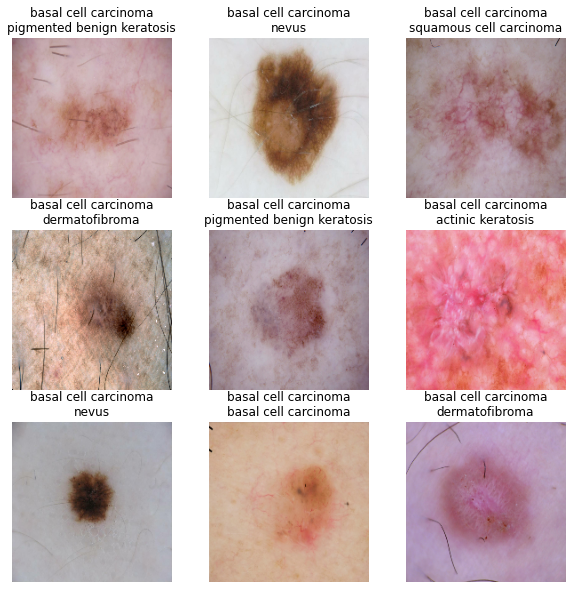

In [92]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")